<a href="https://colab.research.google.com/github/mingyu1021/AI-class/blob/main/9week/TSLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/AI-class/TSLA.csv')

# Date 열을 datetime 형식으로 변환하고 인덱스로 설정 (시각화 시 유용)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Volume 열 제외, Close 열은 타겟으로 분리
df_features = df.drop(columns=['Volume', 'Close'])
df_target = df[['Close']] # DataFrame 형태로 유지

df_target.head()

,Close
Date,
2010-06-29,4.778
2010-06-30,4.766
2010-07-01,4.392
2010-07-02,3.840
2010-07-06,3.222


In [ ]:
# --- 2. 데이터 스케일링 ---
# 특성(Features) 스케일링
scaler_features = MinMaxScaler()
features_scaled = scaler_features.fit_transform(df_features)

# 타겟(Target - Close) 스케일링 (별도의 Scaler 사용)
scaler_target = MinMaxScaler()
target_scaled = scaler_target.fit_transform(df_target)

In [ ]:
# 3. 시퀀스 생성
window = 60   # 최근 60일
X, y = [], []
num_features = features_scaled.shape[1] # 특성 개수 (Open, High, Low, Adj Close -> 4)

for i in range(len(features_scaled) - window):
    # i부터 i+window_size 까지의 특성 데이터를 X (입력)
    X.append(features_scaled[i : i + window])
    # i+window_size 시점의 종가(Close) 데이터를 y (정답)
    y.append(target_scaled[i + window])

# NumPy 배열로 변환
X, y = np.array(X), np.array(y)

X

array([[[4.64594174e-04, 1.34982149e-03, 4.21744904e-04, 1.31893210e-03],
        [1.56759922e-03, 2.22389944e-03, 1.37067094e-03, 1.30915016e-03],
        [1.43926727e-03, 1.49818896e-03, 8.71496305e-04, 1.00427957e-03],
        ...,
        [7.35878185e-04, 7.61189655e-04, 8.53374453e-04, 8.57550414e-04],
        [7.71616198e-04, 7.93443454e-04, 9.37393946e-04, 8.10271019e-04],
        [7.68367288e-04, 6.96682057e-04, 7.94066576e-04, 6.63541861e-04]],

       [[1.56759922e-03, 2.22389944e-03, 1.37067094e-03, 1.30915016e-03],
        [1.43926727e-03, 1.49818896e-03, 8.71496305e-04, 1.00427957e-03],
        [1.11437624e-03, 1.04341040e-03, 6.14495504e-04, 5.54310154e-04],
        ...,
        [7.71616198e-04, 7.93443454e-04, 9.37393946e-04, 8.10271019e-04],
        [7.68367288e-04, 6.96682057e-04, 7.94066576e-04, 6.63541861e-04],
        [6.09170683e-04, 5.66054172e-04, 7.44643345e-04, 6.13001817e-04]],

       [[1.43926727e-03, 1.49818896e-03, 8.71496305e-04, 1.00427957e-03],
        

In [ ]:
# ---------------------------------------------------
# [수정] 4. 훈련 데이터, 테스트 데이터 분리 (순서 유지)
# ---------------------------------------------------
# 시계열 데이터는 순서가 중요하므로, 앞부분(예: 80%)을 훈련용,
# 뒷부분(예: 20%)을 테스트용으로 사용합니다.
split_ratio = 0.8
split_point = int(len(X) * split_ratio)

X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]
X_train

array([[[4.64594174e-04, 1.34982149e-03, 4.21744904e-04, 1.31893210e-03],
        [1.56759922e-03, 2.22389944e-03, 1.37067094e-03, 1.30915016e-03],
        [1.43926727e-03, 1.49818896e-03, 8.71496305e-04, 1.00427957e-03],
        ...,
        [7.35878185e-04, 7.61189655e-04, 8.53374453e-04, 8.57550414e-04],
        [7.71616198e-04, 7.93443454e-04, 9.37393946e-04, 8.10271019e-04],
        [7.68367288e-04, 6.96682057e-04, 7.94066576e-04, 6.63541861e-04]],

       [[1.56759922e-03, 2.22389944e-03, 1.37067094e-03, 1.30915016e-03],
        [1.43926727e-03, 1.49818896e-03, 8.71496305e-04, 1.00427957e-03],
        [1.11437624e-03, 1.04341040e-03, 6.14495504e-04, 5.54310154e-04],
        ...,
        [7.71616198e-04, 7.93443454e-04, 9.37393946e-04, 8.10271019e-04],
        [7.68367288e-04, 6.96682057e-04, 7.94066576e-04, 6.63541861e-04],
        [6.09170683e-04, 5.66054172e-04, 7.44643345e-04, 6.13001817e-04]],

       [[1.43926727e-03, 1.49818896e-03, 8.71496305e-04, 1.00427957e-03],
        

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# --- 5. 조기 종료 콜백 정의 ---
early_stopping = EarlyStopping(monitor='val_loss',
                              patience=10,        # 10 epoch 동안 개선 없으면 중단
                              restore_best_weights=True) # 최적 가중치 복원

In [ ]:
# Define input layer separately
inputs = tf.keras.layers.Input(shape=(window, num_features)) # Shape should be (60, 4)

# Build RNN layers on top of the input
x = tf.keras.layers.SimpleRNN(64, return_sequences=True)(inputs)
x = tf.keras.layers.SimpleRNN(32)(x) # No return_sequences needed for the last RNN layer before Dense
outputs = tf.keras.layers.Dense(1)(x)

# Create the model using the defined inputs and outputs
model_RNN = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model (same as before)
model_RNN.compile(optimizer='adam', loss='mse')

# --- Train the model (same as before) ---
history_RNN = model_RNN.fit(X_train, y_train,
                            epochs=100,
                            batch_size=32,
                            verbose=1,
                            validation_data=(X_test, y_test),
                            callbacks=[early_stopping])

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0623 - val_loss: 0.0572
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.3379e-05 - val_loss: 0.0610
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.6104e-05 - val_loss: 0.0621
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.0678e-05 - val_loss: 0.0632
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.9115e-05 - val_loss: 0.0623
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.8993e-05 - val_loss: 0.0615
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.8382e-05 - val_loss: 0.0619
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.8031e-05 - val_loss: 0.0608
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3256e-05 - val_loss: 0.0609
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3313e-05 - val_loss: 0.0588
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3875e-05 - val_loss: 0.0579


In [ ]:
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window, num_features)), # 입력 형태 지정
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2), # 과적합 방지
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2), # 과적합 방지
    tf.keras.layers.Dense(1) # 출력층 (종가 1개 예측)
])

model_LSTM.compile(optimizer='adam', loss='mse')

history_LSTM = model_LSTM.fit(X_train, y_train,
                             epochs=100, # 충분히 크게 설정 (조기종료 사용)
                             batch_size=32,
                             verbose=1,
                             validation_data=(X_test, y_test),
                             callbacks=[early_stopping]) # 조기 종료 적용


Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 1.6220e-04 - val_loss: 0.0049
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6983e-05 - val_loss: 0.0045
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.4672e-05 - val_loss: 0.0035
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2766e-05 - val_loss: 0.0033
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1189e-05 - val_loss: 0.0034
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.2888e-06 - val_loss: 0.0034
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.8958e-06 - val_loss: 0.0028
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.4766e-06 - val_loss: 0.0030
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0178e-05 - val_loss: 0.0031
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.0005e-06 - val_loss: 0.0025
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.1167e-06 - val_loss: 0.0024
Epoch 12

In [ ]:
print("\n--- RNN 예측 수행 ---")
pred_RNN_scaled = model_RNN.predict(X_test)

print("\n--- LSTM 예측 수행 ---")
pred_LSTM_scaled = model_LSTM.predict(X_test)

# --- 8. 결과 분석 (스케일 복원 및 평가) ---
# 스케일 복원
y_test_inv = scaler_target.inverse_transform(y_test)
pred_RNN_inv = scaler_target.inverse_transform(pred_RNN_scaled)
pred_LSTM_inv = scaler_target.inverse_transform(pred_LSTM_scaled) # LSTM 예측값 복원 추가


--- RNN 예측 수행 ---
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

--- LSTM 예측 수행 ---
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
from sklearn.metrics import mean_squared_error

mse_rnn_original = mean_squared_error(y_test_inv, pred_RNN_inv)
mse_lstm_original = mean_squared_error(y_test_inv, pred_LSTM_inv)

print(f"\n--- 원래 데이터 스케일 기준 (Sales 값) ---")
print(f"RNN 모델 MSE (Original): {mse_rnn_original:,.2f}")
print(f"LSTM 모델 MSE (Original): {mse_lstm_original:,.2f}")


--- 원래 데이터 스케일 기준 (Sales 값) ---
RNN 모델 MSE (Original): 86,082.38
LSTM 모델 MSE (Original): 2,647.79


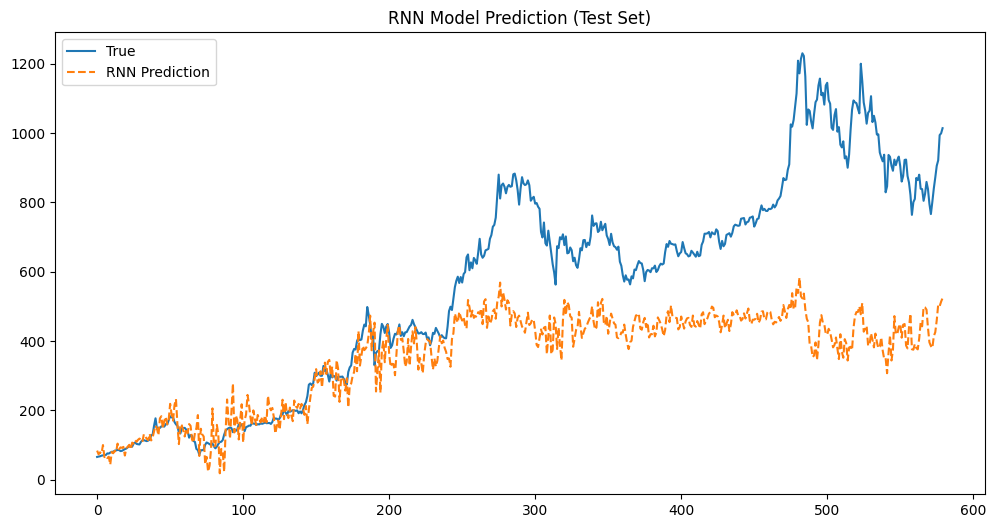

In [ ]:
# 6-1. RNN 예측 시각화
plt.figure(figsize=(12, 6))
plt.title('RNN Model Prediction (Test Set)')
plt.plot(y_test_inv, label='True')
plt.plot(pred_RNN_inv, label='RNN Prediction', linestyle='--')
plt.legend()
plt.show()

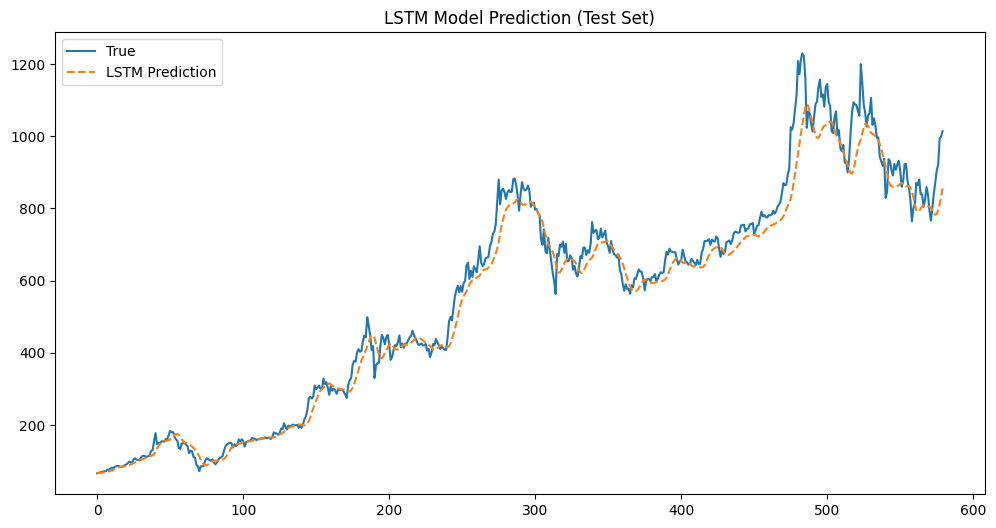

In [ ]:
# 6-2. LSTM 예측 시각화
plt.figure(figsize=(12, 6))
plt.title('LSTM Model Prediction (Test Set)')
plt.plot(y_test_inv, label='True')
plt.plot(pred_LSTM_inv, label='LSTM Prediction', linestyle='--')
plt.legend()
plt.show()

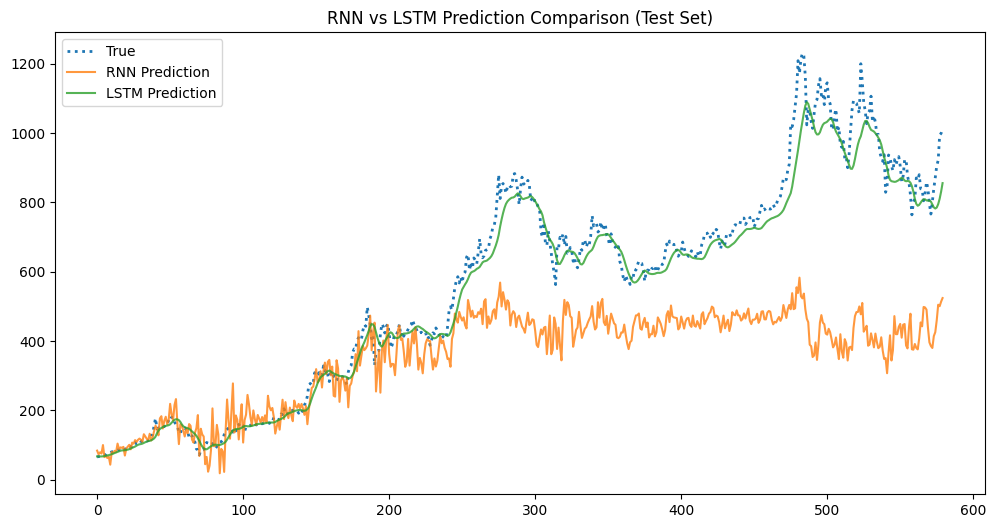

In [ ]:
# 6-3. RNN vs LSTM 비교 시각화
plt.figure(figsize=(12, 6))
plt.title('RNN vs LSTM Prediction Comparison (Test Set)')
plt.plot(y_test_inv, label='True', linewidth=2, linestyle=':')
plt.plot(pred_RNN_inv, label='RNN Prediction', alpha=0.8)
plt.plot(pred_LSTM_inv, label='LSTM Prediction', alpha=0.8)
plt.legend()
plt.show()